# Dependencies

In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

In [2]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [3]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Preprocess the raw data

### Read the CSV

In [5]:
df = pd.read_csv("Resources/exoplanet_data.csv")

### Perform Basic Data Cleaning

In [6]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [7]:
df.columns

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

### Select significant features (columns)
Perform feature selection based upon physical characteristics of the exoplanet candidates. These will also be used as X values.<br>I will mainly select features related to the appearance and physical characteristics. They would be checked off in the following lists. Also, if there is a feature that might result from a linear combination of other features, then that would be unchecked off.

KOI = Kepler Objects of Interest<br> It is a number used to identify and track a Kepler Object of Interest. A KOI is a target identified by the Kepler Project that displays at least one transit-like sequence within Kepler time-series photometry that appears to be of astrophysical origin and initially consistent with a planetary transit hypothesis.

#### Project Disposition Columns
Flags designate the most probable physical explanation of the KOI.

- [x] koi_fpflag_nt: Not Transit-Like Flag - KOI whose light curve is not consistent with that of a transiting planet.
- [x] koi_fpflag_ss: Stellar Eclipse Flag - A KOI that is observed to have a significant secondary event, transit shape, or out-of-eclipse variability.
- [x] koi_fpflag_co: Centroid Offset Flag - The source of the signal is from a nearby star.
- [x] koi_fpflag_ec: Ephemeris Match Indicates Contamination Flag - The KOI shares the same period and epoch as another object.

#### Transit Properties
Transit parameters delivered by the Kepler Project are typically best-fit parameters produced by a Mandel-Agol (2002) fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris. Some of the parameters listed below are fit directly, other are derived from the best-fit parameters.

- [x] koi_period: Orbital Period (days) - The interval between consecutive planetary transits.
- [x] koi_period_err1: Orbital Period (days) - Uncertainties Column (positive +)
- [ ] koi_period_err2: Orbital Period (days) - Uncertainties Column (negative -)
- [x] koi_time0bk: Transit Epoch - The time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days.
- [x] koi_time0bk_err1: Transit Epoch - Uncertainties Column (positive +)
- [ ] koi_time0bk_err2: Transit Epoch - Uncertainties Column (negative -)
- [x] koi_impact: Impact Parameter - The sky-projected distance between the center of the stellar disc and the center of the planet disc at conjunction, normalized by the stellar radius.
- [x] koi_impact_err1: Impact Parameter - Uncertainties Column (positive +)
- [ ] koi_impact_err2: Impact Parameter - Uncertainties Column (negative -)
- [x] koi_duration: Transit Duration (hours) - The duration of the observed transits.
- [x] koi_duration_err1: Transit Duration (hours) - Uncertainties Column (positive +)
- [ ] koi_duration_err2: Transit Duration (hours) - Uncertainties Column (negative -)
- [x] koi_depth: Transit Depth (parts per million) - The fraction of stellar flux lost at the minimum of the planetary transit.
- [x] koi_depth_err1: Transit Depth (parts per million) - Uncertainties Column (positive +)
- [ ] koi_depth_err2: Transit Depth (parts per million) - Uncertainties Column (negative -)
- [x] koi_prad: Planetary Radius (Earth radii) - The radius of the planet. Planetary radius is the product of the planet star radius ratio and the stellar radius.
- [x] koi_prad_err1: Planetary Radius (Earth radii) - Uncertainties Column (positive +)
- [x] koi_prad_err2: Planetary Radius (Earth radii) - Uncertainties Column (negative -)
- [x] koi_teq: Equilibrium Temperature (Kelvin) - Approximation for the temperature of the planet.
- [x] koi_insol: Insolation Flux [Earth flux]
- [x] koi_insol_err1: Insolation Flux [Earth flux] - Uncertainties Column (positive +)
- [x] koi_insol_err2: Insolation Flux [Earth flux] - Uncertainties Column (negative -)

#### Threshold-Crossing Event (TCE) Information
The Transiting Planet Search (TPS) module of the Kepler data analysis pipeline performs a detection test for planet transits in the multi-quarter, gap-filled flux time series. The TPS module detrends each quarterly PDC light curve to remove edge effects around data gaps and then combines the data segments together, filling gaps with interpolated data so as to condition the flux time series for a matched filter. 

- [x] koi_model_snr: Transit Signal-to-Noise - Transit depth normalized by the mean uncertainty in the flux during the transits.
- [x] koi_tce_plnt_num: TCE Planet Number - TCE Planet Number federated to the KOI.

#### Stellar Parameters
Stellar effective temperature, surface gravity, metallicity, radius, mass, and age should comprise a consistent set.

- [x] koi_steff: Stellar Effective Temperature (Kelvin) - The photospheric temperature of the star.
- [x] koi_steff_err1: Stellar Effective Temperature (Kelvin) - Uncertainties Column (positive +)
- [x] koi_steff_err2: Stellar Effective Temperature (Kelvin) - Uncertainties Column (negative -)
- [x] koi_slogg: Stellar Surface Gravity - The base-10 logarithm of the acceleration due to gravity at the surface of the star.
- [x] koi_slogg_err1: Stellar Surface Gravity - Uncertainties Column (positive +)
- [x] koi_slogg_err2: Stellar Surface Gravity - Uncertainties Column (negative -)
- [x] koi_srad: Stellar Radius (solar radii) - The photospheric radius of the star.
- [x] koi_srad_err1: Stellar Radius (solar radii) - Uncertainties Column (positive +)
- [x] koi_srad_err2: Stellar Radius (solar radii) - Uncertainties Column (negative -)

#### Kepler Input Catalog (KIC) Parameters

- [x] ra: RA (deg) - KIC Right Ascension of the planetary system in decimal degrees
- [x] dec: Dec (deg) - 	KIC Declination in decimal degrees
- [x] koi_kepmag: Kepler-band (mag) - Kepler-band (mag), it is a magnitude computed according to a hierarchical scheme and depends on what pre-existing catalog source is available.

In [8]:
# Selected features
feature_names = ['koi_fpflag_nt', 
        'koi_fpflag_ss',
        'koi_fpflag_co',
        'koi_fpflag_ec',
        'koi_period',
        'koi_period_err1',
        'koi_time0bk',
        'koi_time0bk_err1',
        'koi_impact',
        'koi_impact_err1',
        'koi_duration',
        'koi_duration_err1',
        'koi_depth',
        'koi_depth_err1',
        'koi_prad',
        'koi_prad_err1',
        'koi_prad_err2',
        'koi_teq',
        'koi_insol',
        'koi_insol_err1',
        'koi_insol_err2',
        'koi_model_snr',
        'koi_tce_plnt_num',
        'koi_steff',
        'koi_steff_err1',
        'koi_steff_err2',
        'koi_slogg',
        'koi_slogg_err1',
        'koi_slogg_err2',
        'koi_srad',
        'koi_srad_err1',
        'koi_srad_err2',
        'ra',
        'dec',
        'koi_kepmag'
       ]
X = df[feature_names]
X.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_time0bk,koi_time0bk_err1,koi_impact,koi_impact_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,0,0,0,0,54.418383,2.479000e-04,162.513840,0.003520,0.586,0.059,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,0,1,0,0,19.899140,1.490000e-05,175.850252,0.000581,0.969,5.126,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,0,1,0,0,1.736952,2.630000e-07,170.307565,0.000115,1.276,0.115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,0,0,0,0,2.525592,3.760000e-06,171.595550,0.001130,0.701,0.235,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,0,0,0,0,4.134435,1.050000e-05,172.979370,0.001900,0.762,0.139,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


Use `koi_disposition` for the y values

In [9]:
y = df["koi_disposition"]
y.head()

0         CONFIRMED
1    FALSE POSITIVE
2    FALSE POSITIVE
3         CONFIRMED
4         CONFIRMED
Name: koi_disposition, dtype: object

### Spliting the data into training and testing data.

In [10]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_time0bk,koi_time0bk_err1,koi_impact,koi_impact_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
6122,0,0,0,0,6.768901,7.380000e-05,133.077240,0.008440,0.150,0.305,...,-171,4.327,0.153,-0.187,1.125,0.310,-0.207,294.40472,39.351681,14.725
6370,0,1,0,1,0.733726,6.060000e-06,132.020050,0.007950,0.291,0.193,...,-175,4.578,0.033,-0.187,0.797,0.211,-0.056,284.50391,42.463860,15.770
2879,1,0,0,0,7.652707,6.540000e-05,134.460380,0.006190,0.970,0.879,...,-189,4.481,0.050,-0.200,0.963,0.290,-0.097,295.50211,38.983540,13.099
107,0,0,0,0,7.953547,1.910000e-05,174.662240,0.001820,0.300,0.145,...,-85,4.536,0.056,-0.016,0.779,0.023,-0.049,291.15878,40.750271,15.660
29,0,0,0,0,4.959319,5.150000e-07,172.258529,0.000083,0.831,0.016,...,-77,4.359,0.110,-0.110,1.082,0.173,-0.130,292.16705,48.727589,15.263


### Scaling the data

Scaling the data using the MinMaxScaler

In [11]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
X.shape

(6991, 35)

In [13]:
y.shape

(6991,)

# Original Model

### Loop through the neighbors

k: 1, Train/Test Score: 1.000/0.786
k: 3, Train/Test Score: 0.895/0.811
k: 5, Train/Test Score: 0.876/0.814
k: 7, Train/Test Score: 0.863/0.820
k: 9, Train/Test Score: 0.854/0.827
k: 11, Train/Test Score: 0.846/0.825
k: 13, Train/Test Score: 0.847/0.820
k: 15, Train/Test Score: 0.842/0.822
k: 17, Train/Test Score: 0.837/0.824
k: 19, Train/Test Score: 0.835/0.820
k: 21, Train/Test Score: 0.836/0.823
k: 23, Train/Test Score: 0.838/0.825
k: 25, Train/Test Score: 0.835/0.822
k: 27, Train/Test Score: 0.835/0.819
k: 29, Train/Test Score: 0.835/0.819


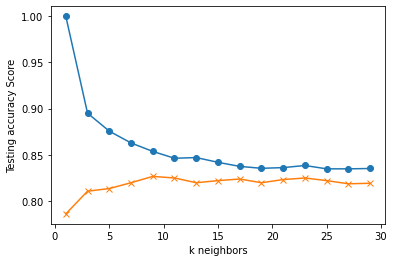

In [14]:
train_scores = []
test_scores = []
for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 30, 2), train_scores, marker='o')
plt.plot(range(1, 30, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

According to the score results, it seems that k: 23 provides the best accuracy where the classifier starts to stablize

In [15]:
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train_scaled, y_train)
print('k=23 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=23 Test Acc: 0.825


In [16]:
model = knn

# Hyperparameter Tuning

### Create the `GridSearchCV` model to find best/tuned parameters

In [17]:
param_grid = {'n_neighbors':[3,5,11,19],
             'weights': ['uniform','distance'],
             'metric': ['euclidean','manhattan']}
grid_model = GridSearchCV(model, param_grid, verbose=1, cv=3, n_jobs=-1)

# Train the model with GridSearch
_ = grid_model.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


### Find Tuned parameters

In [18]:
print(f"Best Parameters: {grid_model.best_params_}")
print(f"Best Score: {round(grid_model.best_score_*100,3)}%")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best Score: 83.082%


# Tuned Model

### Create the model with specific parameters

In [19]:
# Tuned model based upon best parameters previously found
tuned_model = KNeighborsClassifier(n_neighbors=grid_model.best_params_['n_neighbors'],
                                   metric=grid_model.best_params_['metric'],
                                   weights=grid_model.best_params_['weights'])

### Train the Model

In [20]:
# Fit and score the tuned model
tuned_model.fit(X_train_scaled, y_train)

tuned_training_score = round(tuned_model.score(X_train_scaled, y_train)*100,3)
tuned_accuracy = round(tuned_model.score(X_test_scaled, y_test)*100,3)

print(f"Training Data Score: {tuned_training_score} %")
print(f"Testing Data Score: {tuned_accuracy} %")

Training Data Score: 100.0 %
Testing Data Score: 82.895 %


### Classification report

In [21]:
# Make predictions with the hypertuned model
predictions = tuned_model.predict(X_test_scaled)

# Calculate classification report
print(classification_report(y_test, predictions, target_names=["CANDIDATE","FALSE POSITIVE","CONFIRMED"]))

                precision    recall  f1-score   support

     CANDIDATE       0.69      0.55      0.61       411
FALSE POSITIVE       0.68      0.77      0.72       484
     CONFIRMED       0.98      1.00      0.99       853

      accuracy                           0.83      1748
     macro avg       0.78      0.77      0.77      1748
  weighted avg       0.83      0.83      0.83      1748

